<a href="https://colab.research.google.com/github/pcarbomestre/SAR-VesselDetection-FisheriesMonitoring/blob/main/detectron2_register.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Registering data with Detectron2

### Load libraries

The virtual machines used in Colab for the runtimes are ephemeral, so some libraries not preinstalled in Colab environment have to be installed each time we open the notebook. More information about Colab [here](https://colab.research.google.com/github/tensorflow/workshops/blob/master/extras/amld/notebooks/solutions/0_colab.ipynb#scrollTo=fPP3Zw5iV2DP).

Detectron2 is a library that provides state-of-the-art detection and segmentation algorithms. It is not installed by default in the Colab environmebt so we have to install it each time we open a session.

More information about it at https://github.com/facebookresearch/detectron2.

In [ ]:
# Install detectron2:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
exit(0) # After installation restart Colab's runtime.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-f2pv6oa1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-f2pv6oa1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4e447553eb32b6e3784df0b8fca286935107b2fd
  Preparing metadata (setup.py) ... done


Detectron2 is built on top of PyTorch. Therefore, it requires PyTorch to be imported in order to run it. Beside we will load all detecron2 utilities and other commmon libraries we are going to use.

In [ ]:
import yaml
import torch, torchvision

# Detectron2
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# import some common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, json, cv2, random
import pickle

We also need to connect to our Google Drive accoung where we have stored our datasets, and where we are going to save our outputs.

In [ ]:
# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

Now lets define the directories we are gonna call and read the necessary files.

In [ ]:
# Global paths (Using SSDD default folder structure)
root = '/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/'
annotations_path = root + 'data/annotations/'
dest = root + 'data/datasets/'
imagesets = root + 'data/imagesets/'

In [ ]:
labels_df = pd.read_csv(annotations_path + 'labels.csv')
grouped = labels_df.groupby('filename')

test = pd.read_csv(imagesets + 'test.txt', header = None, names = ['file'])
test_offshore = pd.read_csv(imagesets + 'test_offshore_in_test.txt', header = None, names = ['file'])
test_inshore = pd.read_csv(imagesets + 'test_inshore_in_test.txt', header = None, names = ['file'])
train = pd.read_csv(imagesets + 'train.txt', header = None, names = ['file'])

Here we define a function that converts our annotations to Detectron's format. The code based on [Colab Detectron tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).

In [ ]:
# Function that converts annotations to Detectron's format
# and then saves a pickle output to path
def standardize(path, annotations, df, grouped):
  # Create a list of annotation ids without the file extension
  anns_id = [i.split('.')[0] for i  in annotations]
  # Create a DataFrame with the annotation ids and their respective file names
  anns_df = pd.DataFrame(anns_id, columns=['file'])
  # Merge the DataFrame with the annotation file names with the DataFrame containing the image file names
  anns_df = df.merge(df, on='file', how='inner')
  # Create a dictionary with default values for each image file, including the file name, dimensions, image id and an empty list for annotations
  std = {i: {
        "file_name": df.loc[df['file'] == i]['type'].values[0] + i +'.jpg',
        "height": 800, # All images of the same dimension
        "width": 800, # All images of the same dimension
        "image_id": i,
        "annotations": []
        } for i in df['file'].values
      }
  # Iterate over each image file and overwrite the default annotations with the correct annotations
  keys = grouped.groups.keys()
  for i in keys:
    if i.split('.')[0] in std:
      j = grouped.get_group(i)
      temp = []
      for index, row in j.iterrows():
        # Create a dictionary for each annotation with its bounding box coordinates, mode and category id
        ann_temp = {
            'bbox' : [
                      row['xmin'],
                      row['ymin'],
                      row['xmax'],
                      row['ymax']
                      ],
            'bbox_mode': BoxMode.XYXY_ABS,
            'category_id': 0
        }
        temp.append(ann_temp)
      # Overwrite the annotations for the current image with the correct annotations
      std[i.split('.')[0]]['annotations'] = temp
  # Save the standardized annotations dictionary as a pickle file to the specified path
  f = open(path + "standardDict.pkl","wb")
  pickle.dump(list(std.values()),f)
  f.close()
  # Return the standardized annotations dictionary
  return std

In [ ]:
# Add path to each element on the image list contained on the .txt
test['type'] = dest + 'test/'
test_offshore['type'] = dest + 'test_offshore/'
test_inshore['type'] = dest + 'test_inshore/'
train['type'] = dest + 'train/'
# List all .xml annotations in the directory
anns = os.listdir(annotations_path + 'vessel/')

In [ ]:
# Make standardized annotations (converts annotations to Detectron's format)
test_std = standardize(dest + 'test/', anns, test, grouped)
test_offshore_std = standardize(dest + 'test_offshore/', anns, test_offshore, grouped)
test_inshore_std = standardize(dest + 'test_inshore/', anns, test_inshore, grouped)
train_std = standardize(dest + 'train/', anns, train, grouped)

In [ ]:
# Verification
print(len(test_std) + len(train_std))
print(len(anns))
print(len(test_offshore_std))
print(len(test_inshore_std))

print(train_std['01_18_12'])

1859
1859
618
117


In [ ]:
# Function that retrieves the standard datasets compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/Shareddrives/ssdd_pcarbomestre/SSDD_pcarbomestre_2.0/data/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

The get_dict function loads a standard dataset from a .pkl file and returns it as a list of dictionaries, using the previously defined type argument to construct the path to the file.

In [ ]:
train_dict = get_dict('train')
test_dict = get_dict('test')
test_offshore_dict = get_dict('test_offshore')
test_inshore_dict = get_dict('test_inshore')

# Verify
print(len(train_dict)+ len(test_dict)) # check
print(len(train_dict))
print(len(test_dict))
print(len(test_offshore_dict))
print(len(test_inshore_dict))

1859
1123
736
618
117


## Verify annotation conversion

We can verify if the annotations have been properly converted by displaying the images with the corresponding labels in Detectron format.

In [ ]:
for d in ["train", "test"]:
    MetadataCatalog.get(d).set(thing_classes=["ship"])
train_metadata = MetadataCatalog.get('train')

namespace(name='train', thing_classes=['ship'])

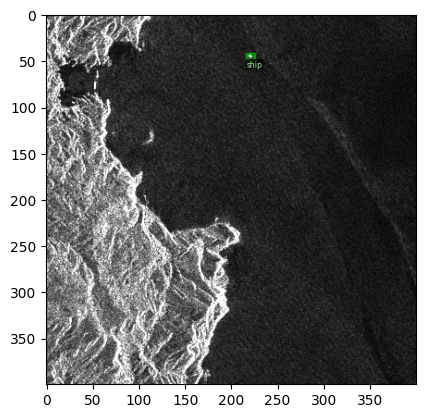

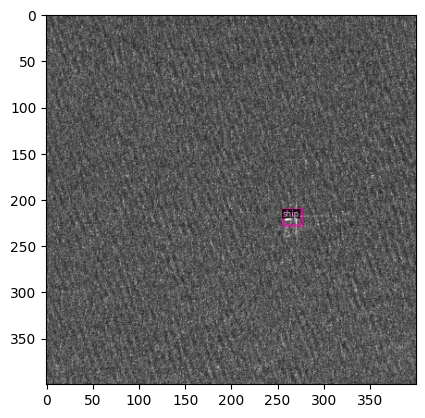

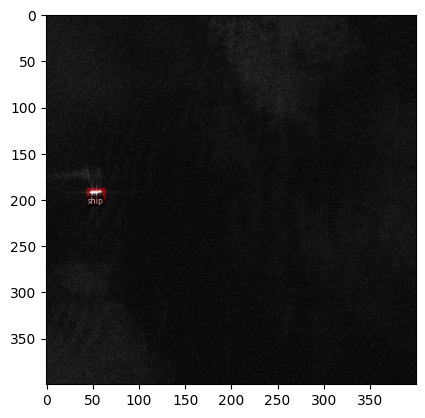

In [ ]:
dataset_dicts = train_dict
# Display 3 random images
random.seed(123)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1]) # use cv2_imshow for colab
    plt.show()